# Interpolation and Polynomial Approximation

## Introduction

- Interpolation _vs_ Approximation
- why interpolation or approximation?
- The principles
  - base functions
    - power series: $1$, $x$, $x^2$, $\cdots$
    - trigonometric functions: $\sin(nx)$
    - eigen-functions of the problem.
  - How to construct
    - match derivatives at a single point: **Taylor expansion**
    - pass through some given points: **Interpolation**
    - minimize an _overall_ error: **Approximation**
- Polynomials
  - local approximation
  - Convergence and error bound

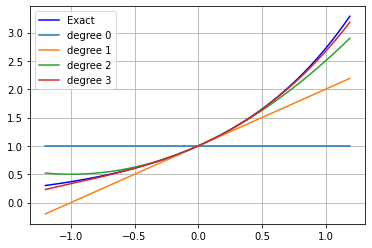

In [1]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(-1.2, 1.2, 0.01)

plt.plot(t, np.exp(t), 'b-', label='Exact')

y = np.zeros_like(t)
for i in range(4):
    y += t ** i / np.math.factorial(i)
    plt.plot(t, y, label='degree %d' %(i))

plt.legend()
plt.grid()
plt.show()

## Taylor Polynomial Approximation

Assume that $f\in C^{N+1}[a,b]$, and $x_0\in [a,b]$ is a fixed value, $\forall x\in [a,b]$, we have:
$$ f(x) = \sum_{k=0}^N\frac{f^{(k)}(x_0)}{k!}(x-x_0)^k + E_N(x),$$
where $E_N(x)$ is the error term:
$$ E_N(x) = \frac{f^{(N+1)}(c)}{(N+1)!}(x-x_0)^{N+1},$$
where $c=c(x)$ lies between $x$ and $x_0$

- Matches the leading derivatives at $x_0$;
- A _local_ approximation, bad if $x$ is away from $x_0$;
- Not very useful as usuauly we don't know the derivatives beforehand.

## <span style="color:red">Exercises</span>

>- Section 4.1: Problems 20, 21

### Evaluation of polynomials

To exaluate the $N$-th order polynomial $P(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + a_4 x^4 + \cdots + a_N x^N$ directly, it takes $1 + 2 + 3 + \cdots + N = N(N+1)/2 = O(N^2)$ multiplications.

In [66]:
def polynomial(x, a) :
    p = 0.
    for i in range(len(a)):
        p += a[i] * pow(x, i)  # notice the python 'for' statment syntax
    return p

Horner's method: $N$ multiplications:
$$
P(x) = a_0 + x (a_1 + x(a_2 + \cdots x a_N)).
$$
$O(N)$ complexity.

In [67]:
def polynomial_horner(x, a) :
    p = 0.
    for ai in reversed(a):
        p = p * x + ai
    return p

Test the two methods:

In [68]:
N = 6
a = np.random.random(N)
x = .5
print(polynomial(x, a))
print(polynomial_horner(x, a))

1.0133496647565576
1.0133496647565579


#### Programming technique: Object-Oriented design

In the funciton interfaces aboce, $a$ is the coefficient array, which is really associated with the **polynomial** itself, while $x$ is an externally supplied parameter.  We want to create a *function object* that is created with the coefficients, and can evaluate the function value of any given parameter:

In [69]:
class polynomial :
    """ an object representing a polynomial """
    def __init__(self, a):
        self._a = a

    def evaluate(self, x) :
        _p = 0.
        for i in reversed(self._a):
            _p = _p * x + i
        return _p
    
    # define a function returns the degree of the polynomial

Use it like this:

In [70]:
p = polynomial(a)

print(p.evaluate(x))
#
# we can also print out the coefficients:
#
print(p._a[0])

1.0133496647565579
0.3600541557018454


Let's plot it:

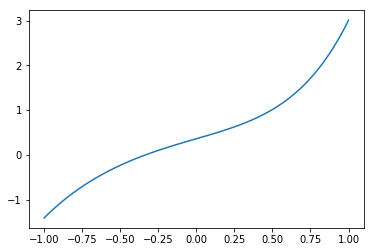

In [71]:
x = np.linspace(-1., 1., 100)
y = p.evaluate(x)
    
plt.plot(x, y)

plt.show()

We want to embed the ploting code to the **polynomial** object itself to
1. keep things cleaner (no x, y laying around)
2. reused it easily

In [72]:
class polynomial :
    """ an object representing a polynomial """
    def __init__(self, a) :
        self.a = a

    def evaluate(self, _x) :
        _p = 0.
        for i in reversed(self.a):
            _p = _p * _x + i
        return _p

    def plot(self, x0=-1., x1=1.) :
        _x = np.linspace(x0, x1, 100)
        _y = self.evaluate(_x)

        plt.plot(_x, _y)

Now we can say:

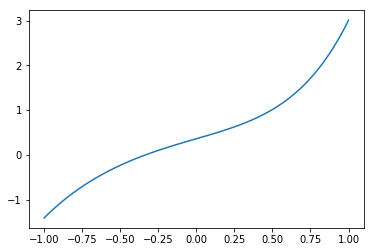

In [73]:
p = polynomial(a)

p.plot()

## Collocation polynomials

Given $N+1$ data point, $\{x_i, y_i\}$, $i = 0, \cdots N$, find the unique $N$-th order polynomial $P(x)$ such that $P(x_i) = y_i$ for $i = 0, \cdots, N$.

### Method 1: Solving a linear equation

Let $P(x) = a_0 + a_1 x + a_2 x^2 + \cdots + a_N x^N$, or more compactly:
$$
P(x) = \sum_{k=0}^Na_k x^k.
$$
We need to find the $N+1$ coefficients, $a_k$, $k = 0, 1, \cdots, N$.

Using the explicit expression above, we have $N+1$ linear equations about the $N+1$ unknowns, $a_k$:
$$
\sum_{i=0}^Na_k x^k_i = P(x_i) = y_i,\quad\mbox{for all points:}\quad i = 0, 1, \cdots, N.
$$
Written in matrix form:
$$
\left(\begin{array}{ccccc}
1 & x_0 & x_0^2 & \cdots & x_0^N\\
1 & x_1 & x_1^2 & \cdots & x_1^N\\
\vdots & \vdots & \vdots && \vdots\\
1 & x_N & x_N^2 & \cdots & x_N^N
\end{array}\right)
\left(\begin{array}{c}
a_0 \\
a_1 \\
\vdots \\
a_N
\end{array}\right) =
\left(\begin{array}{c}
y_0 \\
y_1 \\
\vdots \\
y_N
\end{array}\right).
$$
The matrix is called **Vandermonde Matrix**.

Now let's write a program that finds the polynomial coefficients for any given set of points.

In [74]:
def interpolate(points):
    #
    # make sure input is an N x 2 array of the form ((x0, y0), (x1, y1), ... (x_N-1, y_N-1))
    #
    assert len(points.shape) == 2
    #
    # N is the length of the array
    #
    N = len(points)
    #
    # create a N x N matrix
    #
    x = np.empty((N, N))
    #
    # fill the matrix
    #
    j = 0
    for p in points:
        for i in range(N) :
            x[j,i] = pow(p[0], i)
        j += 1
    #
    # solve the lienar equation using SciPy pacakge.
    #
    return np.linalg.solve(x, points[:,1])

To test it, we first create a list of $N$ points:

[[0.43521699 0.97025609]
 [0.78415221 0.62004017]
 [0.83443553 0.40147037]
 [0.26322393 0.52982737]]


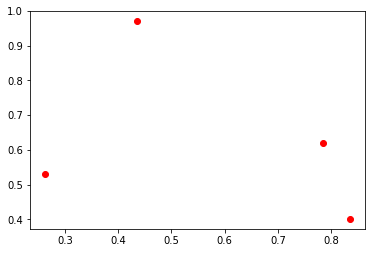

In [75]:
N = 4
points = np.random.random((N, 2))
print(points)

plt.plot(points[:,0], points[:,1], 'ro')
plt.show()

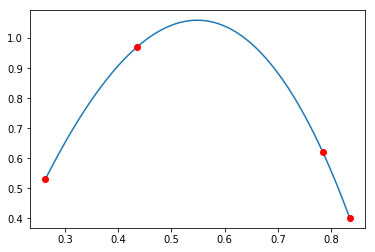

In [76]:
# get the coefficients of the interpolating polynomial

a = interpolate(points)

# contstruct a polynomial object

p = polynomial(a)

# let's plot the polynomial and the original data points.

p.plot(points[:,0].min(), points[:,0].max())

plt.plot(points[:,0], points[:,1], 'ro')

### Method 2: Lagrange polynomials

Given $N+1$ data point, $\{x_i, y_i\}$, $i = 0, \cdots N$, we find a set of $N+1$ **base functions**, $L_j(x)$, $j = 0, \cdots, N$, each of which is an $N$-th degree polynomial, and $L_j(x)$ satisfy the conditions:
$$
L_j(x_i) = \left\{\begin{array}{ll}
            1 & i = j\\
            0 & i \neq j
            \end{array}\right.
$$

1. Once we have the base function $L_i(x)$, it is straightforward that
$$
P(x) = \sum_{i=0}^N y_iL_i(x),
$$
is an $N$-th degree polynomial, and $P(x_i) = y_i$;
- $L_j(x)$ can be explicitly constructed:
$$
L_j(x) = \frac{(x - x_0)\cdots(x - x_{j-1})(x - x_{j+1})\cdots(x - x_N)}{(x_j - x_0)\cdots(x_j - x_{j-1})(x_j - x_{j+1})\cdots(x_j - x_N)}.
$$

- No solution of linear equation is needed
- Direct evaluation needs $O(N^2)$ multiplications

In [77]:
class polynomial_L :
    """ polynomial based on Lagrange polynomials """
    def __init__(self, points) :

        self._points = points
        self._denominators = np.zeros(len(points))
        
        for j in range(len(points)) :
            terms = points[j,0] - points[:,0]  # note the array syntax
            terms[j] = 1                       # eliminate the i-th term
            self._denominators[j] = points[j,1] / np.prod(terms)

    def evaluate(self, x) :

        terms = x - self._points[:,0]       # array of (x - x_i)
        numerators = np.empty_like(terms)   # an empty array of same size

        for i in range(len(terms)):
            tmp = terms[i]                  # save terms[i]
            terms[i] = 1.                   # temporarily set terms[i] to 1
            numerators[i] = np.prod(terms)  # compute the numerators
            terms[i] = tmp                  # restore terms[i]
        
        return np.dot(numerators, self._denominators)

Test:

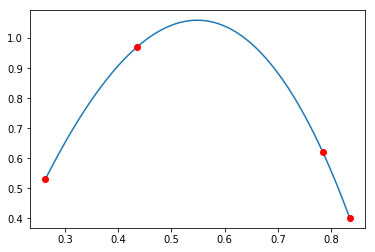

In [78]:
pl = polynomial_L(points)

x = np.linspace(points[:,0].min(), points[:,0].max(), 100)

for i in range(len(x)):
    y[i] = pl.evaluate(x[i])

plt.plot(x,y)
plt.plot(points[:,0], points[:,1],'ro')

#### Uniqueness

An $N$-th order polynomial has at most $N$ zeros.

#### Error Estimate

Assume that $f(x)\in C^{N+1}[a,b]$, and $x_0, \cdots, x_N\in [a,b]$ are $N+1$ nodes, $f(x)$ can be approximated as:
$$
f(x) = \sum_{i=0}^N f(x_i)L_i(x) + E_N(x),
$$
where the error term:
$$
E_N(x) = \frac{(x - x_0)(x - x_1)\cdots(x - x_N)f^{(N+1)}(c)}{(N+1)!},
$$
and $c = c(x)\in [a,b]$.  Note $E_N(x_i) = 0.$

#### Equally spaced nodes 

If $x_i = x_0 + ih$,
$$
E_N \cong O(h^{N+1})
$$

## <span style="color:red">Exercises</span>

>- Section 4.3: Problems 1, 13

### Method 3: Newton polynomials

The $N$-th degree polynomials can have many different sets of basis, _e.g._, $x^k$ (most common), the Lagrange polynomials $L_k(x)$, etc.

#### Newton's polynomials
$$
\begin{eqnarray}
n_0(x) &=& 1\\
n_1(x) &=& x - x_0\\
n_2(x) &=& (x - x_1)(x - x_0)\\
&\cdots&\\
n_k(x) &=& \prod_{i=0}^{k-1}(x - x_i)
\end{eqnarray}
$$
#### Properties:
1. Evaluation of first $N$ polynomials takes only $N$ multiplications.
2. Progressive, more points can be added if needed without wasting previous work.
3. Coefficients are easy to compute

Any $N$-th polynomial can be written as:
$$
P(x) = \sum_{i=0}^Na_i n_i(x).
$$
Notice that $n_i(x_j) = 0$ iff $j < i$, the equations $P(x_i) = y_i$ yield a triangle matrix:
$$
\left(\begin{array}{ccccc}
1 &       0 & 0 & \cdots & 0\\
1 & x_1-x_0 & 0 & \cdots & 0\\
1 & x_2-x_0 & (x_2-x_1)(x_2-x_0) & \cdots & 0\\
\vdots & \vdots & \vdots & & \vdots\\
1 & x_N-x_0 & (x_N-x_1)(x_N-x_0) & \cdots & \prod_{i=0}^{N-1}(x_N-x_i)
\end{array}\right)
\left(\begin{array}{c}
a_0 \\
a_1 \\
a_2 \\
\vdots \\
a_N
\end{array}\right) =
\left(\begin{array}{c}
y_0 \\
y_1 \\
y_2 \\
\vdots \\
y_N
\end{array}\right).
$$

The solutions are in a _recursive_ form:
$$
\begin{eqnarray}
a_0 &=& y_0\\
a_1 &=& \frac{y_1 - y_0}{x_1 - x_0}\\
a_2 &=& \left(\frac{y_2 - y_0}{x_2 - x_0} - \frac{y_1 - y_0}{x_1 - x_0}\right)\left/(x_2 - x_1)\right. =
\left(\frac{y_2 - y_1}{x_2 - x_1} - \frac{y_1 - y_0}{x_1 - x_0}\right)\left/(x_2 - x_0)\right.\\
&\cdots&
\end{eqnarray}
$$

Define the **divided differences**:
$$
\begin{eqnarray}
f[x_0] = \color{red}{f(x_0)} &&&&\\
&\color{red}{f[x_0,x_1]}&&&\\
f[x_1] = f(x_1)&&\color{red}{f[x_0,x_1,x_2]}&&\\
&f[x_1,x_2]    &&\color{red}{f[x_0,x_1,x_2,x_3]}&\\
f[x_2] = f(x_2)&&f[x_1,x_2,x_3]    &&\color{red}{f[x_0,x_1,x_2,x_3,x_4]}\\
&f[x_2,x_3]    &&f[x_1,x_2,x_3,x_4]&\\
f[x_3] = f(x_3)&&f[x_2,x_3,x_4]&&\\
&f[x_2,x_4]&&&\\
f[x_4] = f(x_4)&&&&
\end{eqnarray}
$$
In general, (Neville's algorithm)
$$
f[x_{k-j},x_{k-j+1},\cdots,x_k] = \frac{f[x_{k-j+1},\cdots,x_k] - f[x_{k-j},\cdots,x_{k-1}]}{x_k - x_{k-j}},
\quad\mbox{and,}\quad
a_k = f[x_0,\cdots,x_k].
$$

## <span style="color:red">Exercises</span>

>- Re-write Program 4.2 in python
>- Section 4.4: **P&A** 1, 2
>- Combine all python codes in this notebook into a single class, and time the three methods of polynomial approximation. You can ignore the one-time setup time. Be as thorough as possible.

## Runge's phenomenon

### The basis for approximating an arbitrary function with a polynomial: 

The **Weierstrass Approximation Theorem** states that for every continuous function f(x) defined on an interval $[a,b]$, there exists a set of polynomial functions $P_n(x)$ for $n=0, 1, 2,\cdots$, that approximates $f(x)$ with **uniform convergence** over $[a,b]$ as n tends to infinity, that is,
$$
\lim _{n\rightarrow\infty}\left(\max _{a\leq x\leq b}\left|f(x)-P_{n}(x)\right|\right)=0.
$$
The question is: how to find it?

A streightforward method: pick $n$ equally spaced points on $f(x)$ and draw a polynomial through these points.  This does't always work for certain functions such as the Runge function:
$$
f(x) = \frac{1}{1 + 12 x^2}.
$$
The reason is that $\max| f^{(n)}(x)|\rightarrow\infty$ as $n\rightarrow\infty$.
$$
\begin{eqnarray}
f'(x) &=& -\frac{24x}{(1+12x^2)^2}\\
f''(x) &=& -\frac{24(1-36x^2)}{(1+12x^2)^3}\\
f^{(3)}(x) &=& \frac{3456x(1-12x^2)}{(1+12x^2)^4}
\end{eqnarray}
$$

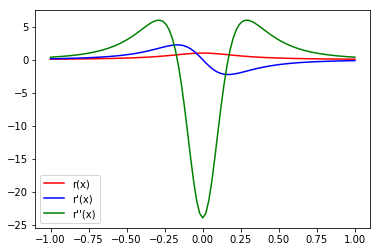

In [90]:
def runge(x):
    return 1./(1+12*x*x)

def runge1(x):
    return -24 * x / pow(1+12*x*x, 2)

def runge2(x):
    return -24 * (1-36*x*x) / pow(1+12*x*x, 3)

def runge3(x):
    return 3456 * (1-12*x*x) / pow(1+12*x*x, 4)

x=np.linspace(-1., 1., 101)

plt.plot(x, runge(x),  'r-', label="r(x)")
plt.plot(x, runge1(x), 'b-', label="r'(x)")
plt.plot(x, runge2(x), 'g-', label="r''(x)")
#plt.plot(x, runge3(x), 'k-', label="r'''(x)")

plt.legend()
plt.show()

Polynomials obtained by interpolation on equally-space points do not converge!

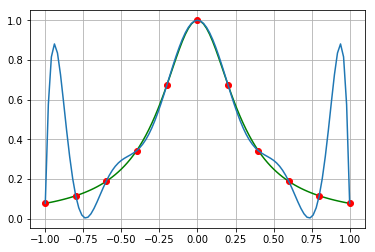

In [96]:
plt.grid()
#
# plot the Runge function
#
plt.plot(x, runge(x), 'g-')
#
# number of initerpolation points
#
n=11
#
# equally spaced coordinates
#
a = np.linspace(-1, 1, n)
#
# make a list of pairs:
#
points = np.transpose([a, runge(a)])
#
# plot the chosen points
#
plt.plot(a, runge(a), 'ro')
#
# create a polynomial passing through points (Larange polynomial)
#
p = polynomial_L(points)
#
# evaluate and plot
#
px = np.empty_like(x)
for i in range(len(x)):
    px[i] = p.evaluate(x[i])

plt.plot(x, px)
plt.show()

## Chebyshev polynomials

Choose the collocation points, $x_0, x_1, \cdots, x_N$, to minimize error.

### Classical orthogonal polynomials:

- In _functional analysis_, an _inner product_ with respect to a _weight function_, $\omega(x)$, is defined as:
$$
\langle f,g\rangle \equiv \int \omega(x)f(x)g(x)dx.
$$
Think the dot-product of two vectors.

- Two functions, $f$ and $g$, are said to be orthogonal if $\langle f,g\rangle = 0$. (two perpendicular, or orthogonal, vectors)

- Orthogonal polynomial sequence, $P_n(x)$, $n = 0, \cdots, \infty$, is a family of polynomials satisfying:

  * $P_n$ is an $n$-th degree polynomial;
  * Ortho-normal: $\langle P_m, P_n\rangle = \left\{\begin{array}{ll}
      0 & m\neq n\\
      1 & m = n
      \end{array}\right.$. $P_n(x)$ are similar to the base vectors $\mathbf{x}, \mathbf{y}, \mathbf{z}$ in three-dimensional Euclidean space.
  * $P_n(x)$ can be constructed explicitly through the **Gram-Schmidt** procedure.

- A family of orthgonal polunomials form a complete basis of the given functional space, _i.e._ for any function $f(x)$:
$$f(x) = \sum_{n=0}^\infty a_nP_n(x),$$
where $a_n$ are the _expansion coefficeints_ given by
$$a_n = \int\omega(x)f(x)P_n(x)dx.$$
Any vector in Euclidean space can be expanded as $\mathbf{v} = v_x\mathbf{x}+v_y\mathbf{y}+v_z\mathbf{z}$ with $v_x = \mathbf{v}\cdot\mathbf{x}$,  $v_y = \mathbf{v}\cdot\mathbf{y}$, $\cdots$.  The expansion is called the _general Fourier expansion_. 

- Orthogonal polynomials arise from the **Sturm-Liuville problem**, they are solutions to the **Sturm-Liuville** equation:
$$
\frac d{dx}\left[p(x)\frac{dy}{dx}\right] + q(x)y = -\lambda w(x)y,
$$
and some boundary conditions.

- The most commonly used families are the **Classical Orthogonal Polynomials**:
$$
\begin{array}{lcc}
Jocobi   & \omega = (1-x)^\alpha(1+x)^\beta & [-1,+1]           \\
Hermite  & \omega = \exp(-x^2)              & (-\infty,+\infty) \\
Laguerre & \omega = x^\alpha\exp(-x)        & [0,\infty)
\end{array}
$$

### Chebyshev polynomials:

Chebyshev polynomial is a special form of Jocobi polynomial with $\alpha = \beta = 1/2$.

**Recurrence relation:**

$$
\begin{eqnarray}
T_0(x)     &=& 1\\
T_1(x)     &=& x\\
T_{n+1}(x) &=& 2xT_n(x)-T_{n-1}(x).
\end{eqnarray}
$$

**Trigonometric definition:**

$$
T_n(\cos\theta)=\cos n\theta
$$

**Chebyshev nodes**

$T_N(x)$ has $N$ zeros in $[-1,1]$:
$$
x_k=\cos\left(\frac{(2k+1)\pi}{2N}\right),\quad\mbox{for}\quad k = 0, 1, \cdots, N-1.
$$

**Arbitrary interval**

The arbitrary interval $x\in[a,b]$ can be mapped to the interval of $y\in[-1,1]$ by the linear transform of shift and scaling:
$$
y = \frac{2(x-a)}{b-a}-1.
$$

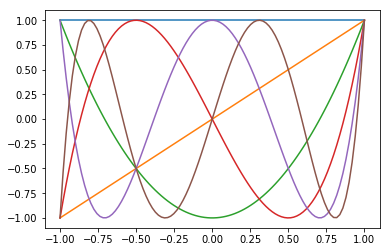

In [81]:
# plot chebyshev polynomials up to order N

import numpy.polynomial.chebyshev as cbs

N=6
for i in range(N):
    order = np.zeros(N)
    order[i] = 1
    c = cbs.Chebyshev(order)
    p = c.linspace()

    plt.plot(p[0], p[1])
    
plt.show()

In [104]:
# compute the chebyshev nodes

def tn(n):
    """ returns the N chebyshev nodes """
    tn = np.empty(n)
    for k in range(n):
        tn[k] = np.cos((2. * k + 1) * np.pi / (2. * n))
    return tn

a=tn(21)

print(a)

[ 9.97203797e-01  9.74927912e-01  9.30873749e-01  8.66025404e-01
  7.81831482e-01  6.80172738e-01  5.63320058e-01  4.33883739e-01
  2.94755174e-01  1.49042266e-01  6.12323400e-17 -1.49042266e-01
 -2.94755174e-01 -4.33883739e-01 -5.63320058e-01 -6.80172738e-01
 -7.81831482e-01 -8.66025404e-01 -9.30873749e-01 -9.74927912e-01
 -9.97203797e-01]


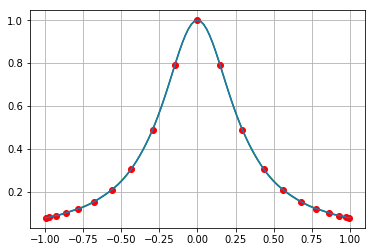

In [105]:
plt.grid()
plt.plot(x, runge(x), 'g-')

#
# make a list of pairs:
#
points = np.transpose([a, runge(a)])
#
# plot the chosen points
#
plt.plot(a, runge(a), 'ro')
#
# create a polynomial passing through points (Larange polynomial)
#
p = polynomial_L(points)
#
# evaluate and plot
#
px = np.empty_like(x)
for i in range(len(x)):
    px[i] = p.evaluate(x[i])

plt.plot(x, px)
plt.show()

- the error of a Lagrange approximation achieves minimum at the Chebyshev nodes
$$
\max|(x-x_0)(x-x_1)\cdots(x-x_N)|
$$
is minimum if $\{x_i\}$ are the Chebyshev nodes.
- for an absolutely continous function, the Lagrange-Chebyshev approximation converges uniformly

### <span style="color:red">Exercises</span>

> Rewrite Program 4.3 in Python and do all the problems in Algorithms and Programs of Sec. 4.5.

## Pade Approximation